In [1]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import cv2
import os
import math
import numpy as np 
from scipy.ndimage.morphology import distance_transform_edt

# FUNCTIONS

def getPathToImages(datasetIndex):
    relativePathFolder = ''
    startImgIndex = 0
    outputSavePath = ''
    
    if datasetIndex ==0:
        relativePathFolder = 'images/arena/source_images/'
        startImgIndex = 4
        outputSavePath = 'images/arena/'
    elif datasetIndex == 1:
        relativePathFolder = 'images/big_house/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/big_house/'
    elif datasetIndex == 2:
        relativePathFolder = 'images/bridge/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/bridge/'
    elif datasetIndex == 3:
        relativePathFolder = 'images/building_site/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/building_site/'
    elif datasetIndex == 4:
        relativePathFolder = 'images/carmel/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/carmel/'
    elif datasetIndex == 5:
        relativePathFolder = 'images/diamondhead/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/diamondhead/'
    elif datasetIndex == 6:
        relativePathFolder = 'images/fishbowl/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/fishbowl/'
    elif datasetIndex == 7:
        relativePathFolder = 'images/golden_gate/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/golden_gate/'
    elif datasetIndex == 8:
        relativePathFolder = 'images/halfdome/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/halfdome/'
    elif datasetIndex == 9:
        relativePathFolder = 'images/hotel/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/hotel/'
    elif datasetIndex == 10:
        relativePathFolder = 'images/office/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/office/'
    elif datasetIndex == 11:
        relativePathFolder = 'images/ponte_nuovo/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/ponte_nuovo/'
    elif datasetIndex == 12:
        relativePathFolder = 'images/rio/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/rio/'
    elif datasetIndex == 13:
        relativePathFolder = 'images/river/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/river/'
    elif datasetIndex == 14:
        relativePathFolder = 'images/roof/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/roof/'
    elif datasetIndex == 15:
        relativePathFolder = 'images/san_pietro/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/san_pietro/'
    elif datasetIndex == 16:
        relativePathFolder = 'images/shangai/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/shangai/'
    elif datasetIndex == 17:
        relativePathFolder = 'images/yard/source_images/'
        startImgIndex = 0
        outputSavePath = 'images/yard/'
        
    return (relativePathFolder, outputSavePath, startImgIndex)

# Removes black borders from image 
def trim_black_countour(image): 
    mask = np.argwhere(image != 0)

    min_x = np.min(mask[:,1])
    max_x = np.max(mask[:,1])

    min_y = np.min(mask[:,0])
    max_y = np.max(mask[:,0])

    return image[min_y:max_y, min_x:max_x,:]

# Compose the mosaice from 2 images using color adjust 
def blending(I1, I2, blendingOn):

    '''
    WEIGHTENED BLENDING:
    I_blended = (I1 * w1 + I2 * w2)/(w1 + w2)
    I1 = ref_img, I2 = warped_img
    distance_transform_edt gives more weight to the px in the centre of the image and less on the borders.
    Link: https://www.youtube.com/watch?v=D9rAOAL12SY
    '''

    # STITCHING THE TWO IMAGES
    if blendingOn:
        w1 = distance_transform_edt(I1) # This command correspond to the bwdist() in MATLAB
        w1 = np.divide(w1, np.max(w1))
        w2 = distance_transform_edt(I2)
        w2 = np.divide(w2, np.max(w2))
        I_blended = cv2.add(np.multiply(I1, w1), np.multiply(I2, w2))
        w_tot = w1 + w2
        I_blended = np.divide(I_blended, w_tot, out=np.zeros_like(I_blended), where=w_tot != 0).astype("uint8")
    else:
        I_blended = cv2.add(I1,I2)        
    return I_blended

def getMatches(descr_1, descr_2, algorithm):
    # brute force matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    # FlannBasedMatcher
    index_params = dict(algorithm=1, trees=2)
    search_params = dict()
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    if algorithm == 1:
        return bf.match(descr_1, descr_2)
    elif algorithm == 2:
        return matcher.knnMatch(descr_1, descr_2, k = 2)    
    else:
        return []
        
def getSortedMatches(matches, algorithm):
    if algorithm == 1:
        return sorted(matches, key = lambda x:x.distance)
    elif algorithm == 2:
            sortedMatches = []
            for m,n in matches:
                if m.distance < 0.7 * n.distance:
                    sortedMatches.append(m)
            return sortedMatches
    else:
            return []
        
        
def getHMatrix(matches, numberOfPoints, iterations):
    baseImage_idx = matches[0].queryIdx
    bestMatch_idx = matches[0].trainIdx

    pts_base = np.array([[0, 0]])
    pts_bestMatch = np.array([[0, 0]])

    for x in range(numberOfPoints):
        baseImage_idx = bestMatches[x].queryIdx
        best_idx = bestMatches[x].trainIdx

        pts_base = np.concatenate((pts_base, [[base_kp[baseImage_idx].pt[0], base_kp[baseImage_idx].pt[1]]]))
        pts_bestMatch = np.concatenate((pts_bestMatch, [[bestMatchesKeyPoints[best_idx].pt[0], bestMatchesKeyPoints[best_idx].pt[1]]]))
    print("base ", pts_base)
    print("pts_bestMatch ", pts_bestMatch)
    h, status = cv2.findHomography(pts_bestMatch, pts_base, cv2.RANSAC, maxIters = iterations)
    print("st ", status)
    return h


def drawMatches(img1, keypoints1, img2, keypoints2, good_matches):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   # matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    #-- Draw matches
    #img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
    #img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, **draw_params)

    #-- Show detected matches
    plt.imshow(img_matches[:,:,::-1])
    plt.title('Good Matches')
    plt.show()
    # save image
    cv2.imwrite(f"{outputSavePath}matches.jpg", img_matches)

    

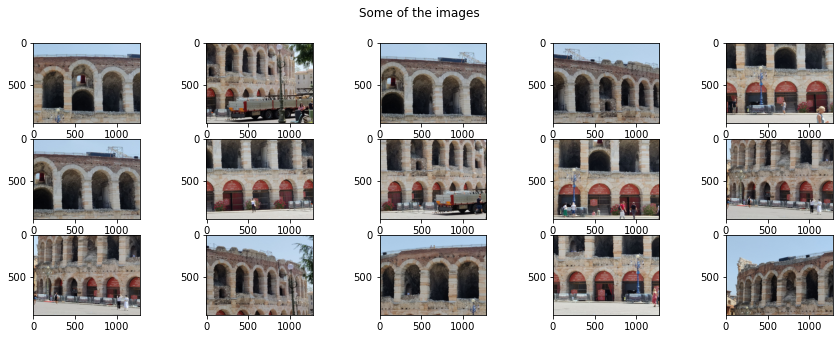

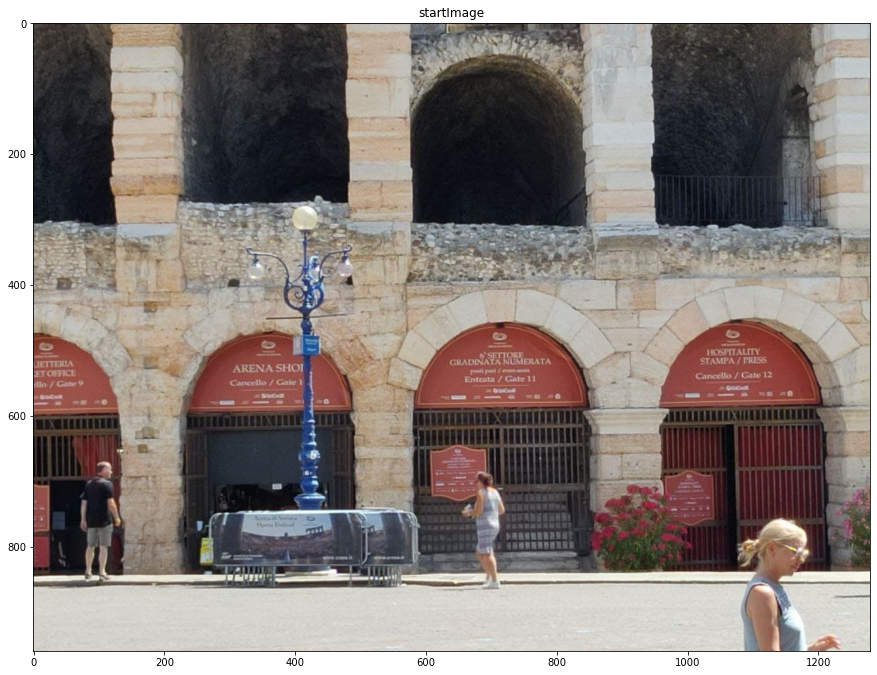

In [4]:
relativePathFolder, outputSavePath, startImgIndex = getPathToImages(0)
saveOutput = False
showMatches = True

images = []
for filename in os.listdir(relativePathFolder):
    img = cv2.imread(os.path.join(relativePathFolder, filename))
    if img is not None:
        images.append(img)

if len(images) < 5:
    fig, ax = plt.subplots(1, len(images), figsize=(15, 12))
    for j in range(len(images)):
        ax[j].imshow(images[j][:,:,::-1])           
else:
    fig, ax = plt.subplots(math.floor(len(images)/5), 5, figsize=(15, 5))
    fig.suptitle('Some of the images')

    k = 0
    for i in range(math.floor(len(images)/5)):
        for j in range(5):
            ax[i,j].imshow(images[k][:,:,::-1])
            k+=1
                           

startImage = images[startImgIndex]

plt.figure(figsize=(15,12))
plt.imshow(startImage[:,:,::-1])
plt.title('startImage')
plt.show()
    
poppedImage = images.pop(startImgIndex)


In [5]:
# EXTRACTING FEATURES

# Get gray images
images_g = []
for i in range(len(images)):
    images_g.append(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY))

#sift 
sift = cv2.SIFT_create()

# compute keypoints and descriptors of all images except baseImage
keypoints = []
descriptors = []
for i in range(len(images)):
    kp, descr = sift.detectAndCompute(images_g[i],None)
    keypoints.append(kp)
    descriptors.append(descr)


In [2]:
# 1 = bruteForce, 2 = flann
MATCHING_ALGORITHM = 2    
numMatchesAlg2 = 0

base_img = startImage

imagesToUseIdx = list(range(len(images)))

imagesAlreadyUsedIdx = []
discardedImagesIdx = []

for i in range(1):
    print("Iteration ", i)
    # Augment base image with black countour, assuming images shape all equal to the one of startImage
    top = int(startImage.shape[0])
    bottom = top
    right = int(startImage.shape[1])
    left = right

    base_img = cv2.copyMakeBorder(base_img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 0)
    base_img_g = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)

    base_kp, base_descr = sift.detectAndCompute(base_img_g, None)
    bestMatchesMeanDistance = 1e10
    bestMatchesImageIdx = 0
    bestMatches = []
    
    # CHOOSING THE BEST IMAGE TO STICH

    numberOfPoints = 4
    
    # The image to stich is the one with lower mean distance value for the first
    # number of matches found
    for j in imagesToUseIdx:
        if j not in imagesAlreadyUsedIdx:
            matches = getMatches(base_descr,  descriptors[j], MATCHING_ALGORITHM)
            orderedMatches = getSortedMatches(matches, MATCHING_ALGORITHM)
            
            
            if len(orderedMatches) > len(bestMatches):
                #bestMatchesMeanDistance = meanDistance
                bestMatches = orderedMatches
                bestMatchesImageIdx = j
                
#             meanDistance = 0
#             for k in range(len(orderedMatches)):
#                 meanDistance += orderedMatches[k].distance

#             meanDistance = meanDistance/len(orderedMatches)

#             if meanDistance < bestMatchesMeanDistance:
#                 bestMatchesMeanDistance = meanDistance
#                 bestMatches = orderedMatches
#                 bestMatchesImageIdx = j
                
    bestMatchesKeyPoints = keypoints[bestMatchesImageIdx]
    imagesAlreadyUsedIdx.append(bestMatchesImageIdx)
    
    if showMatches:
        #img_draw_matches = cv2.drawMatches(before_mosaice, base_kp, images[bestMatchesImageIdx], bestMatchesKeyPoints, bestMatches[:10], None, **draw_params)

        drawMatches(base_img, base_kp, images[bestMatchesImageIdx], keypoints[bestMatchesImageIdx], bestMatches[0:4])
    
    # HOMOGRAPHY COMPUTATION
    h = getHMatrix(bestMatches, numberOfPoints, 5)
   
    # DETERMINANT CHECK
    # The determinant of a transformation matrix can be seen as a scaling factor
    # If det(h) is too big, for ex. greater than 10, the computation was probably wrong
    determinantH = np.linalg.det(h)
    
    if determinantH > 3:
        print("Skipping image ", bestMatchesImageIdx, "\nDeterminant of h too big", np.linalg.det(h),"\nH ", h ,"\n")
        discardedImagesIdx.append(bestMatchesImageIdx)
        
        matches = getMatches(base_descr,  descriptors[bestMatchesImageIdx], 2)
        orderedMatches = getSortedMatches(matches, 2)
        
        H_test = getHMatrix(orderedMatches, len(orderedMatches), 10) 
        determinantH_test = np.linalg.det(H_test)
        print("Determinant with second method: ", determinantH_test)
        if determinantH_test < 3:
            print("image accepted ", determinantH_test)
            h = H_test
        else:
            print("image skipped ")
            continue
        
    # Warped image
    img_warped = cv2.warpPerspective(images[bestMatchesImageIdx], h, (base_img.shape[1], base_img.shape[0]))


    # VISUALIZATION

    before_mosaice = base_img

    base_img = blending(base_img, img_warped, True)

    base_img = trim_black_countour(base_img)

    if True:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img_warped[:,:,::-1])
        ax[0].axis('off') 
        ax[0].set_title("image warped - idx "+str(bestMatchesImageIdx))

        ax[1].imshow(base_img[:,:,::-1])
        ax[1].axis('off')  
        ax[1].set_title("after stiching - iter " + str(i))
    else:
        # https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   # matchesMask = matchesMask, # draw only inliers
                   flags = 2)

        img_draw_matches = cv2.drawMatches(before_mosaice, base_kp, images[bestMatchesImageIdx], bestMatchesKeyPoints, bestMatches[:10], None, **draw_params)
    
out_img = trim_black_countour(base_img)
plt.figure(figsize=(15,12))
plt.imshow(out_img[:,:,::-1])
plt.show()

if saveOutput:
    cv2.imwrite(f"{outputSavePath}final_result.jpg", out_img)


NameError: name 'startImage' is not defined

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(15,12))
# fig.suptitle('Iteration ' + str(i))
# ax[0,0].imshow(images[bestMatchIdx])
# ax[0,0].axis('off')  
# ax[0,0].set_title('bestMatch')

# ax[0,1].imshow(img_warped)
# ax[0,1].axis('off') 
# ax[0,1].set_title('bestMatch warped')

# ax[1,0].imshow(before_mosaice)
# ax[1,0].axis('off') 
# ax[1,0].set_title('before stiching')

# ax[1,1].imshow(base_img)
# ax[1,1].axis('off')  
# ax[1,1].set_title('after stiching')

plt.figure(figsize=(15,12))
plt.imshow(images[bestMatchIdx])
plt.show()

plt.figure(figsize=(15,12))
plt.imshow(before_mosaice)
plt.show()

In [ ]:
# Access coordinates on conjugate points

idx_query = matches[0].queryIdx
idx_train = matches[0].trainIdx

x_1 = int(keypoints_1[idx_query].pt[0])
y_1 = int(keypoints_1[idx_query].pt[1])

x_2 = int(keypoints_2[idx_train].pt[0])
y_2 = int(keypoints_2[idx_train].pt[1])

# image1 = cv2.circle(img1, (x_1, y_1), radius=7, color=(0, 0, 255), thickness=-1)

# image2 = cv2.circle(img2, (x_2, y_2), radius=7, color=(0, 0, 255), thickness=-1)

fig, ax = plt.subplots(1, 2, figsize=(15, 12))

ax[0].imshow(image1)
ax[0].axis('off')  
# ax[1].set_title('1')
ax[1].imshow(image2)
ax[1].axis('off')  
# ax[1].set_title('2')


In [ ]:
# Draw some matches with automatic drawMatches function
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:0], img2, flags=2)

plt.figure(figsize=(15,12))
plt.imshow(img3),
plt.show()

In [ ]:
# Homography computation
import numpy as np 
idx_query = matches[0].queryIdx
idx_train = matches[0].trainIdx

pts_1 = np.array([[keypoints_1[idx_query].pt[0], keypoints_1[idx_query].pt[1]]])
pts_2 = np.array([[keypoints_2[idx_train].pt[0], keypoints_2[idx_train].pt[1]]])

numberOfPoints = 10
for x in range(numberOfPoints):
    idx_query = matches[x].queryIdx
    idx_train = matches[x].trainIdx
    
    pts_1 = np.concatenate((pts_1, [[keypoints_1[idx_query].pt[0], keypoints_1[idx_query].pt[1]]]))
    pts_2 = np.concatenate((pts_2, [[keypoints_2[idx_train].pt[0], keypoints_2[idx_train].pt[1]]]))

h, status = cv2.findHomography(pts_1, pts_2, cv2.RANSAC, 10.0)


In [ ]:
# Warped image
img_warped = cv2.warpPerspective(img1, h, (img1.shape[1],img1.shape[0]))

plt.figure(figsize=(15,12))
plt.imshow(img_warped),
plt.show()


In [ ]:
# Mosaice with the other image
img_out = cv2.add(img2, img_warped)

plt.figure(figsize=(15,12))
plt.imshow(img_out),
plt.show()